In [1]:
import pandas as pd
import numpy as np
import pyemma as pm
import matplotlib.pyplot as plt
# import seaborn as sns 
%matplotlib inline

## Introduction

This notebook makes a simple MSM from reaction coordinates identified by KR and defined in `exploratory/reaction_coordinates`. 

There are 13 bond distances which are reactive (e.g. H -- O, or would involved bond breaking) or stabilizing (hydrogen bonds). Inspection of the distribution of these revealed substantive differences between the two active sites. 

I'll start by investigating the `H` active site as that to appeared to have distinct clusters (by inspection of the free energy diagrams). 

## Data

In [2]:
df = pd.read_csv('../outputs/bond_distances.csv')
df.head()
df.sort_values(by=['Site','Trajectory', 't (ns)'], inplace=True)

In [3]:
dt = df['t (ns)'][1]-df['t (ns)'][0]
dt

0.1

From inspection of the bond distance distributions these are the bond distances which have bimodal distributions. 

In [4]:
h_cols = ['O1-C1', 'O1-H1_2', 'O1-H1_3', 'O2-H1_3', 'HNT-D84_O']
d_cols = ['O2-T172_HG1', 'O1-W160_H']

In [5]:
def split_df(df, cols, site='H'):
    X = []
    for k, v in df.loc[df['Site']==site, :].groupby('Trajectory'):
        X.append(v.loc[:, cols].values)
    return X

In [6]:
X = split_df(df, h_cols, site='H')
X = [x for x in X if x.shape[0]>500]

## No TICA

In [7]:
cluster = pm.coordinates.cluster_mini_batch_kmeans(data=X, k=300, max_iter=100)
dtrajs = cluster.dtrajs

lags = (np.logspace(0, np.log10(500), 10)).astype(int)
its = pm.msm.its(dtrajs, lags = lags, nits=10, errors='bayes')

pm.plots.plot_implied_timescales(its, units = 'ns', dt=dt)
plt.xscale('log')

01-04-20 16:23:02 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[0] INFO     Algorithm did not reach convergence criterion of 1e-05 in 100 iterations. Consider increasing max_iter.


In [11]:
mm = pm.msm.estimate_markov_model(dtrajs, lag=15)

ts = mm.timescales()
plt.plot(np.arange(2, 21), ts[0:19]/ts[1:20], marker='o')
_ = plt.xticks(np.arange(2, 21))


print(['{0:4.2f}'.format(x) for x in ts[:10]*dt])

In [28]:
hmm = mm.coarse_grain(6)

hmm.timescales()*dt

_ = pm.plots.plot_markov_model(hmm)

## With TiCA

In [42]:
tica_obj = pm.coordinates.tica(data=X, lag=10)


In [43]:
Y = tica_obj.get_output()

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13d948950>)

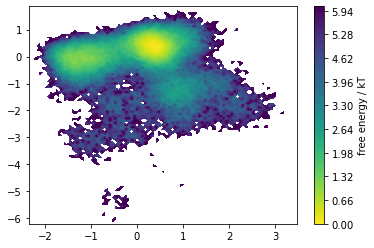

In [47]:
pm.plots.plot_free_energy(np.concatenate(Y)[:, 0], np.concatenate(Y)[:, 1], cmap='viridis_r')

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1424cdf10>)

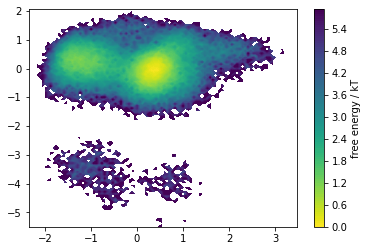

In [48]:
pm.plots.plot_free_energy(np.concatenate(Y)[:, 0], np.concatenate(Y)[:, 2], cmap='viridis_r')

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x142641b10>)

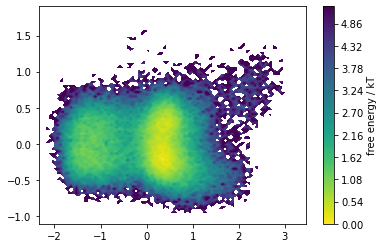

In [49]:
pm.plots.plot_free_energy(np.concatenate(Y)[:, 0], np.concatenate(Y)[:, 3], cmap='viridis_r')

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x142cfd0d0>)

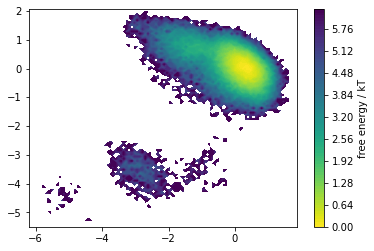

In [50]:
pm.plots.plot_free_energy(np.concatenate(Y)[:, 1], np.concatenate(Y)[:, 2], cmap='viridis_r')

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x143125210>)

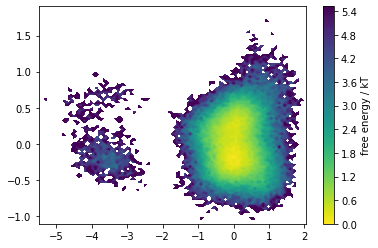

In [51]:
pm.plots.plot_free_energy(np.concatenate(Y)[:, 2], np.concatenate(Y)[:, 3], cmap='viridis_r')

01-04-20 16:55:54 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[11] INFO     Algorithm did not reach convergence criterion of 1e-05 in 100 iterations. Consider increasing max_iter.


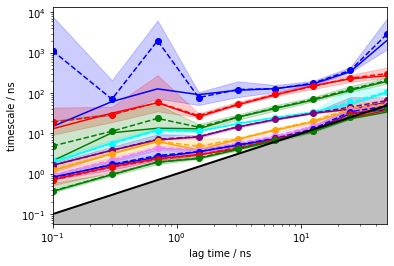

In [52]:
cluster_t = pm.coordinates.cluster_mini_batch_kmeans(data=Y, k=300, max_iter=100)
dtrajs_t = cluster.dtrajs

its_t = pm.msm.its(dtrajs_t, lags = lags, nits=10, errors='bayes')

pm.plots.plot_implied_timescales(its_t, units = 'ns', dt=dt)
plt.xscale('log')

['85.00', '26.07', '13.51', '11.40', '8.27', '3.88', '3.77', '3.45', '3.00', '2.38']


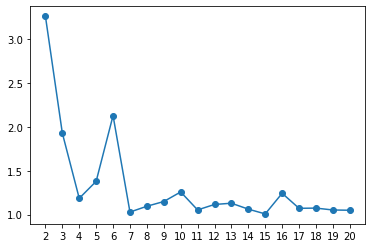

In [55]:
mm_t = pm.msm.estimate_markov_model(dtrajs_t, lag=15)

ts_t = mm_t.timescales()
plt.plot(np.arange(2, 21), ts_t[0:19]/ts_t[1:20], marker='o')
_ = plt.xticks(np.arange(2, 21))


print(['{0:4.2f}'.format(x) for x in ts_t[:10]*dt])

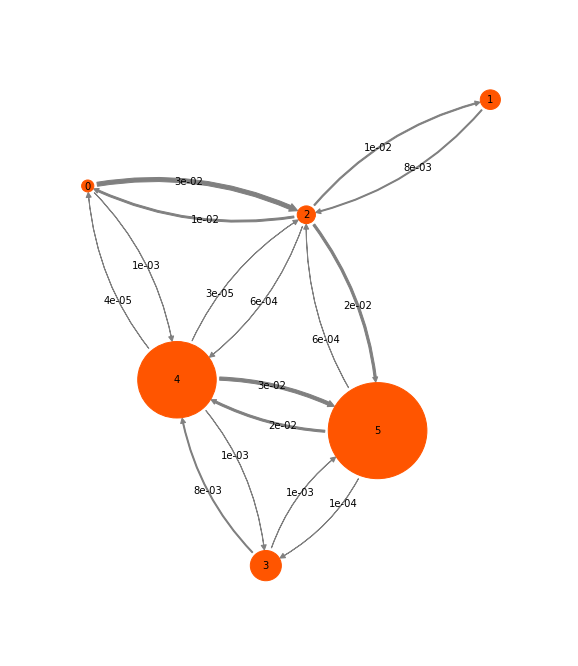

In [57]:
hmm_t = mm_t.coarse_grain(6)

hmm_t.timescales()*dt

_ = pm.plots.plot_markov_model(hmm_t)